In [22]:
# 1. Importing Packages

import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# --- GPU Setup and Debug ---
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Show all TF logs
# tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU(s) detected and memory growth enabled:", gpus)
    except RuntimeError as e:
        print("⚠️ RuntimeError while enabling memory growth:", e)
else:
    print("❌ No GPU detected. Training will run on CPU.")


✅ GPU(s) detected and memory growth enabled: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
# 2. Loading Data
start = time.time()
url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
                      names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

users = pd.read_csv(url_base + "u.user", sep='|', header=None,
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
print("Data loaded in", round((time.time() - start)/60, 2), "minutes")
print(df.head())


Data loaded in 0.09 minutes
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [24]:
# 3. Preprocess Data
start = time.time()
df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on='user_id', how='left')
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').astype(int) // 10**9
df = df.merge(movies, on='item_id', how='left')
df.drop(columns=['IMDb_URL', 'video_release_date', 'unknown'], inplace=True)
df = df.sort_values(by=['user_id', 'timestamp'])
print("Preprocessing done in", round((time.time() - start)/60, 2), "minutes")
print(df.head())

Preprocessing done in 0.0 minutes
       user_id item_id  rating  timestamp  age gender  occupation zip_code  \
59972        1     168       5  874965478   24      M  technician    85711   
92487        1     172       5  874965478   24      M  technician    85711   
74577        1     165       5  874965518   24      M  technician    85711   
48214        1     156       4  874965556   24      M  technician    85711   
15764        1     196       5  874965677   24      M  technician    85711   

                                        title release_date  ...  Fantasy  \
59972  Monty Python and the Holy Grail (1974)  01-Jan-1974  ...        0   
92487         Empire Strikes Back, The (1980)  01-Jan-1980  ...        0   
74577                 Jean de Florette (1986)  01-Jan-1986  ...        0   
48214                   Reservoir Dogs (1992)  01-Jan-1992  ...        0   
15764               Dead Poets Society (1989)  01-Jan-1989  ...        0   

       Film-Noir  Horror  Musical  Myste

In [25]:
# 4. Create item mappings and train-test split
start = time.time()
unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows() if row['item_id'] in item_to_idx}
print("Mappings created in", round((time.time() - start)/60, 2), "minutes")
print(list(item_to_idx.items())[:5])

# Train-test split per user
start = time.time()
def user_based_split(data, test_ratio=0.2):
    train_rows, test_rows = [], []
    for _, group in data.groupby('user_id'):
        n_test = int(len(group) * test_ratio)
        group_sorted = group.sort_values(by='timestamp')
        if n_test > 0:
            test_rows.append(group_sorted.tail(n_test))
            train_rows.append(group_sorted.head(len(group) - n_test))
        else:
            train_rows.append(group_sorted)
    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows)
    return train_df, test_df

train_df, test_df = user_based_split(df, test_ratio=0.2)
print("Train-test split done in", round((time.time() - start)/60, 2), "minutes")
print(train_df.head())
print(test_df.head())

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

Mappings created in 0.0 minutes
[('168', 1), ('172', 2), ('165', 3), ('156', 4), ('196', 5)]
Train-test split done in 0.01 minutes
       user_id item_id  rating  timestamp  age gender  occupation zip_code  \
59972        1     168       5  874965478   24      M  technician    85711   
92487        1     172       5  874965478   24      M  technician    85711   
74577        1     165       5  874965518   24      M  technician    85711   
48214        1     156       4  874965556   24      M  technician    85711   
15764        1     196       5  874965677   24      M  technician    85711   

                                        title release_date  ...  Fantasy  \
59972  Monty Python and the Holy Grail (1974)  01-Jan-1974  ...        0   
92487         Empire Strikes Back, The (1980)  01-Jan-1980  ...        0   
74577                 Jean de Florette (1986)  01-Jan-1986  ...        0   
48214                   Reservoir Dogs (1992)  01-Jan-1992  ...        0   
15764               

In [26]:
# 5. Sequence Tokenization & Creation
start = time.time()
def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)
print("Tokenization done in", round((time.time() - start)/60, 2), "minutes")
print(train_sequences.head())

# Create sequences
start = time.time()
max_seq_len = 50

def create_sequences(sequences):
    input_seqs, labels = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            input_seq = seq[max(0, i - max_seq_len):i]
            label = seq[i]
            input_seq = [0] * (max_seq_len - len(input_seq)) + input_seq
            input_seqs.append(input_seq)
            labels.append(label)
    return np.array(input_seqs, dtype=np.int32), np.array(labels, dtype=np.int32)

train_input, train_labels = create_sequences(train_sequences['item_id'].tolist())
test_input, test_labels = create_sequences(test_sequences['item_id'].tolist())
print("Sequence creation done in", round((time.time() - start)/60, 2), "minutes")
print(train_input[:5])
print(train_labels[:5])

Tokenization done in 0.0 minutes
   user_id                                            item_id
0        1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1        2  [273, 251, 274, 275, 276, 277, 278, 279, 280, ...
2        3  [309, 307, 317, 318, 126, 319, 280, 320, 321, ...
3        4  [251, 276, 309, 345, 255, 280, 349, 347, 356, ...
4        5  [127, 250, 363, 40, 364, 365, 17, 9, 38, 204, ...
Sequence creation done in 0.01 minutes
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 2 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 2 3 4]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 2 3 4 5]]
[2 3 4 5 6]


In [27]:
# 6. Model Architecture (Customizable xLSTM-style)
class xLSTM(tf.keras.Model):
    def __init__(self, vocab_size, hidden_units=128, num_layers=2, dropout_rate=0.2):
        super(xLSTM, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hidden_units)
        self.mlstm_layers = []
        for _ in range(num_layers // 2):
            conv_layer = tf.keras.layers.Conv1D(filters=hidden_units, kernel_size=4, padding='same')
            attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=hidden_units // 4)
            norm_layer = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.mlstm_layers.append((conv_layer, attn_layer, norm_layer))
        self.slstm_layers = []
        for idx in range(num_layers - num_layers // 2):
            lstm_layer = tf.keras.layers.LSTM(
                hidden_units,
                return_sequences=(idx < num_layers - num_layers // 2 - 1),
                dropout=dropout_rate
            )
            norm_layer = tf.keras.layers.LayerNormalization(epsilon=1e-6)
            self.slstm_layers.append((lstm_layer, norm_layer))
        self.exp_gate = tf.keras.layers.Dense(hidden_units, activation='exponential')
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, training=False):
        x = self.embedding(input_ids)
        for conv, attn, norm in self.mlstm_layers:
            conv_out = conv(x)
            attn_out = attn(conv_out, conv_out)
            x = norm(x + attn_out)
            gate = self.exp_gate(x)
            x = x * gate
            x = self.dropout(x, training=training)
        for lstm, norm in self.slstm_layers:
            x = lstm(x, training=training)
            x = norm(x)
        return self.dense(x)

In [28]:
# 7. Model, Training, and Batched Evaluation

import numpy as np
import time

# --- GPU Setup ---
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected! Please set runtime to GPU.")

# --- Data Preparation ---
train_input = np.array(train_input)
train_labels = np.array(train_labels)
test_input = np.array(test_input)
test_labels = np.array(test_labels)

batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_labels)) \
    .shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_labels)) \
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Metric Storage ---
metrics_history = {"recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []}

# --- Batched Evaluation ---
def batched_evaluation(model, test_dataset, top_k=10):
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    total_preds = 0

    for batch_inputs, batch_labels in test_dataset:
        logits = model(batch_inputs, training=False)  # [batch_size, vocab_size]
        logits = logits[:, -1, :] if logits.ndim == 3 else logits  # [batch_size, vocab_size]
        top_k_preds = tf.math.top_k(logits, k=top_k).indices.numpy()  # [batch_size, top_k]
        targets = batch_labels.numpy()

        for pred, label in zip(top_k_preds, targets):
            total_preds += 1
            if label in pred:
                hit += 1
                recall += 1
                precision += 1 / top_k
                rank = np.where(pred == label)[0][0]
                mrr += 1 / (rank + 1)
                dcg = 1 / np.log2(rank + 2)
            else:
                dcg = 0
            idcg = 1 / np.log2(2)
            ndcg += dcg / idcg

    if total_preds == 0: total_preds = 1
    metrics_history["recall@10"].append(recall / total_preds)
    metrics_history["mrr@10"].append(mrr / total_preds)
    metrics_history["ndcg@10"].append(ndcg / total_preds)
    metrics_history["hit@10"].append(hit / total_preds)
    metrics_history["precision@10"].append(precision / total_preds)

# --- Training Loop ---
with tf.device('/GPU:0'):
    model = xLSTM(vocab_size=len(item_to_idx) + 1)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    start = time.time()
    for epoch in range(30):
        print(f"\nEpoch {epoch+1}/10")
        model.fit(
            train_dataset,
            epochs=1,
            verbose=1
        )
        if (epoch + 1) % 5 == 0:
            batched_evaluation(model, test_dataset, top_k=10)
            print(f"Evaluation at epoch {epoch+1}: " +
                  f"recall@10={metrics_history['recall@10'][-1]:.4f}, " +
                  f"mrr@10={metrics_history['mrr@10'][-1]:.4f}, " +
                  f"ndcg@10={metrics_history['ndcg@10'][-1]:.4f}, " +
                  f"hit@10={metrics_history['hit@10'][-1]:.4f}, " +
                  f"precision@10={metrics_history['precision@10'][-1]:.4f}")

    print("Training and evaluation complete in", round((time.time() - start)/60, 2), "minutes")

Num GPUs Available:  1
Memory growth enabled for GPUs

Epoch 1/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 6.6475 - sparse_categorical_accuracy: 0.0066

Epoch 2/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 6.2453 - sparse_categorical_accuracy: 0.0105

Epoch 3/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 6.1035 - sparse_categorical_accuracy: 0.0106

Epoch 4/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 6.0534 - sparse_categorical_accuracy: 0.0126

Epoch 5/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 6.0468 - sparse_categorical_accuracy: 0.0117
Evaluation at epoch 5: recall@10=0.0316, mrr@10=0.0093, ndcg@10=0.0144, hit@10=0.0316, precision@10=0.0032

Epoch 6/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 5.9828 - sparse_categorical_accuracy: 0.0133

Epoch 7/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 5.9564 - sparse_categorical_accuracy: 0.0140

Epoch 8/10
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 5.96

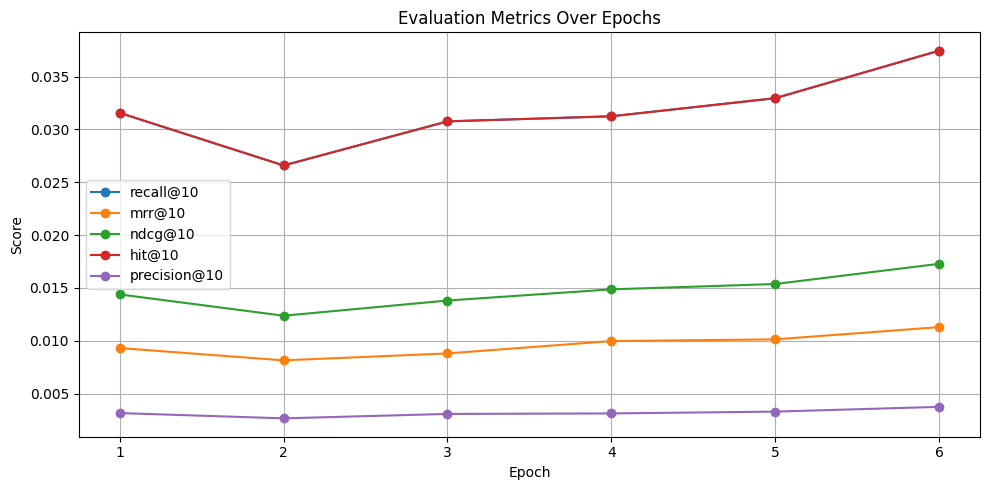


User ID: 1
Recent Sequence: ['Four Rooms (1995)', 'D3: The Mighty Ducks (1996)', 'While You Were Sleeping (1995)', 'Nadja (1994)', 'Net, The (1995)', 'Homeward Bound: The Incredible Journey (1993)', 'Last of the Mohicans, The (1992)', "Carlito's Way (1993)", 'Free Willy (1993)', 'Die Hard 2 (1990)', 'Santa Clause, The (1994)', 'Young Guns (1988)', 'Love Bug, The (1969)', 'Brother Minister: The Assassination of Malcolm X (1994)', 'Bedknobs and Broomsticks (1971)', 'Legends of the Fall (1994)', 'Outbreak (1995)', 'Star Trek: The Wrath of Khan (1982)', 'Dead Man Walking (1995)', 'Wrong Trousers, The (1993)', '12 Angry Men (1957)', 'Searching for Bobby Fischer (1993)', 'French Twist (Gazon maudit) (1995)', 'Remains of the Day, The (1993)', 'Fargo (1996)', "Monty Python's Life of Brian (1979)", 'Dolores Claiborne (1994)', 'Star Trek: First Contact (1996)', 'Contact (1997)', 'Kull the Conqueror (1997)', "My Best Friend's Wedding (1997)", 'Good Will Hunting (1997)', 'Starship Troopers (1997)

In [29]:
# 8. Plotting and explanation
plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Explain predictions
def explain_top_prediction_for_users(model, sequences, user_ids, top_k=1):
    for uid in user_ids:
        user_row = sequences[sequences['user_id'] == uid]
        if user_row.empty:
            continue
        sequence = user_row.iloc[0]['item_id']
        input_seq = sequence[-max_seq_len:]
        padded_seq = [0] * (max_seq_len - len(input_seq)) + input_seq
        input_tensor = tf.convert_to_tensor([padded_seq], dtype=tf.int32)
        logits = model(input_tensor, training=False)
        top_k_tensor = tf.math.top_k(logits, k=top_k)
        top_k_preds = top_k_tensor.indices[0].numpy()
        logits_np = logits[0].numpy()
        print(f"\nUser ID: {uid}")
        print(f"Recent Sequence: {[idx_to_title.get(i, 'UNK') for i in input_seq if i > 0]}")
        for rank, idx in enumerate(top_k_preds):
            item_id = idx_to_item.get(idx, 'UNK')
            title = idx_to_title.get(idx, 'UNK')
            print(f"Prediction #{rank+1}: {title} (Item ID: {item_id}, Logit Score: {logits_np[idx]:.4f})")

explain_top_prediction_for_users(model, test_sequences, user_ids=test_sequences['user_id'].head(5).tolist(), top_k=1)
print("Script finished successfully.")